In [2]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [3]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }
framObjTest = {'img' : [],
           'mask' : []
          }
## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj
        
    
 
    
   

In [4]:
framObjTrain = LoadData( framObjTrain, imgPath = '/home/tonyox/UNet/CamVid/train', maskPath = '/home/tonyox/UNet/CamVid/train_labels'
         , shape = 256)

In [5]:
framObjValidation  = LoadData( framObjValidation, imgPath = '/home/tonyox/UNet/CamVid/val', maskPath = '/home/tonyox/UNet/CamVid/val_labels'
         , shape = 256)

In [6]:
framObjTest  = LoadData( framObjTest, imgPath = '/home/tonyox/UNet/CamVid/test', maskPath = '/home/tonyox/UNet/CamVid/test_labels'
         , shape = 256)

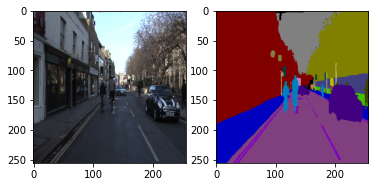

In [7]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

## ATTN _ UNET

In [ ]:
import tensorflow as tf

def attention_gate(F_g, F_l, inter_channels):
    """
    Attention Gate.
    
    Parameters:
    - F_g: Gating signal from the coarser scale.
    - F_l: Feature map from the encoder path.
    - inter_channels: Number of inter channels.
    
    Returns:
    - Attention coefficients applied feature map.
    """
    # Gating signal
    gating = tf.keras.layers.Conv2D(inter_channels, (1, 1), padding='same')(F_g)
    gating = tf.keras.layers.BatchNormalization()(gating)

    # Encoder features
    x = tf.keras.layers.Conv2D(inter_channels, (1, 1), padding='same')(F_l)
    x = tf.keras.layers.BatchNormalization()(x)

    # Combine gating and encoder features
    x = tf.keras.layers.Add()([gating, x])
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(1, (1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('sigmoid')(x)

    # Apply attention coefficients
    return tf.keras.layers.Multiply()([F_l, x])

def Conv2dBlock(inputTensor, numFilters, kernelSize, doBatchNorm):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                          kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                          kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

def GiveMeUnet_attn(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # Encoder Path
    # ... your existing encoder path code ...
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # Decoder Path with Attention Gates
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    attn6 = attention_gate(u6, c4, numFilters*8)  # Attention Gate
    u6 = tf.keras.layers.concatenate([u6, attn6])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    

    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


inputs = tf.keras.layers.Input((128, 128, 3))
Attention_UNET = GiveMeUnet_attn(inputs, droupouts= 0.07)
Attention_UNET.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
attnVal =Attention_UNET.fit(np.array(framObjTrain['img']), np.array(labels_cat), epochs = 500, verbose = 1)
Attention_UNET.save("attn_UNET.h5")

In [ ]:
model_path = '/home/tonyox/UNet/attn_UNET.h5'
model_2 = tf.keras.models.load_model(model_path)

In [ ]:
plt.plot(attnVal.history['loss'], label = 'training_loss')
plt.plot(attnVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [23]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, model_2)

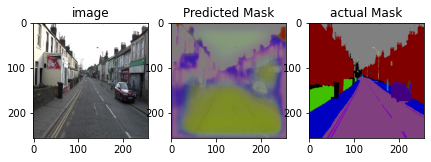

In [24]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])

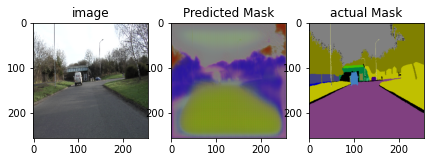

In [25]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

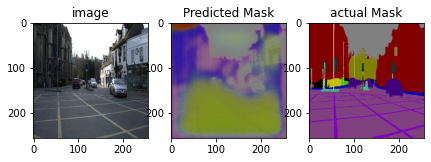

In [26]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

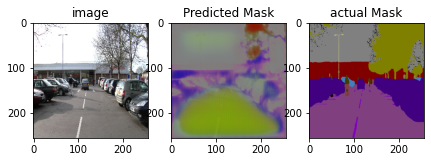

In [27]:
Plotter(actuals[9], sixteenPrediction[9], masks[9])

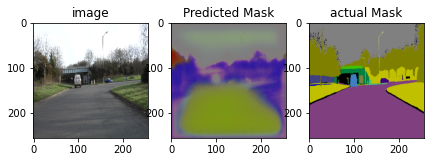

In [28]:
Plotter(actuals[11], sixteenPrediction[11], masks[11])

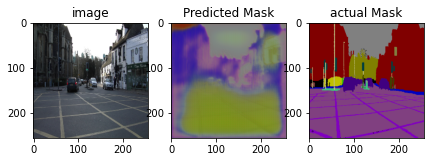

In [29]:
Plotter(actuals[14], sixteenPrediction[14], masks[14])